# Perceptron Algorithm For Classification

This notebook will showcase the usage of a Perceptron algorithm as a linear classifier in two simple classification tasks. Through the classification examples, we are going to cover the learning process behind the Perceptron and also analyze the results of the model fit in the selected classification use cases. In the first classification example we will take a look at the classification task for boolean operators (and, or, nand, nor, xor gates) and in the second example we will fit the model with the famous MNIST dataset.

## About the algorithm

Perceptron was invented by Frank Rosenblatt in 1958 while he was working at Cornell Aeronautical Laboratory. The Perceptron could safely be called “the mother of neural networks.” (as it was in Introduction to AI course by Teemu Roos) as it lays the foundation for the implementation of an artificial neuron - a computational unit that in various forms is now widely applied by the machine learning practitioners.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import mnist_reader

dataset = json.load(open("./test_data.json", "r"))  # dataset for boolean opers

## Initialize functions to train the algorithm

### Functions for training the Perceptron algorithm

- fit_perceptron: trains the weights and returns trained weights vector and misclassification rate per epoch
- predict: get vector or matrix product given data and weights

In [3]:
def predict(x, coefs):
    return x@coefs

def fit_perceptron(X, y, learning_rate=0.5, max_epochs=1):
    coefs = np.random.rand(X.shape[1])  # initialize with random weights
    cls_errors = []  # store classification errors for each epoch
    for i in range(max_epochs):
        y_hats = []
        for j, x in enumerate(X):
            y_hat = -1 if predict(x, coefs) < 0 else 1
            y_hats.append(y_hat)
            # Update coefs for current time step
            coefs = coefs + learning_rate * (y[j]-y_hat) * x

        y_hats = np.array(y_hats)
        cls_error = (y_hats != y).mean()
        cls_errors.append(cls_error)

    return coefs, np.array(cls_errors)

### Utility functions

- add bias term to data (column vector of ones)
- calculate decision boundary
- convert real value outputs into binary classes based on threshold
- calculate classification accuracy

In [4]:
def insert_intercept(X):
    """ Inserts intercept (bias) to 0 index for 1d or 2d tensors (vector or matrix) """
    if len(X.shape) == 1:  # vector
        X = np.insert(X, 0, [1])
    elif len(X.shape) == 2:  # matrix
        bias_vec = np.ones(X.shape[0])
        X = np.insert(X, 0, bias_vec, axis=1)  # X with bias terms (1's) in first index
    return X

def decision_function2d(x1, coefs):
    """
    Returns second coordinate range for drawing hyperplane in a 2 dimensional space.

    Args:
    - x1: first coordinate range
    - coefs: coefs[0]=intercept, coefs[1]=x1_weight, coefs[2]=x2_weight

    Solving the formula for decision function:
    => y = c0 + c1x1 + c2x2
    => 0 = c0 + c1x1 + c2x2  # 0 is the classification threshold in our step function
    => -c2x2 = c0 + c1x1
    => -x2 = (c0 + c1x1) / c2
    => x2 = -(c0 + c1x1) / c2
    """
    return (-coefs[0] - coefs[1]*x1)/coefs[2]

def convert_labels(y, threshold=0):
    """ Converts labels from real value domain to binary classes [-1, 1] based on threshold. """
    y_new = [1 if e >= 0 else -1 for e in y]
    return np.array(y_new)


def accuracy(y_true, y_pred):
    """ Calculates classification accuracy score. Misclassification error = 1 - accuracy_score """
    true_mask = (y_true == y_pred)
    return true_mask.sum() / true_mask.shape[0]


### testing/debugging out functions above

In [5]:
tmp_x = np.random.rand(4, 3)
tmp_c = np.random.rand(3)

obs = np.array([x@tmp_c for x in tmp_x])
obs2 = predict(tmp_x, tmp_c)

print(obs, obs2)
print(np.array_equal(obs, obs2))

[0.90409972 0.40553235 0.38277334 0.10208381] [0.90409972 0.40553235 0.38277334 0.10208381]
True


## Part 1. Find decision boundaries for solving boolean operator truth tables

## 1.1 Plotting AND, OR, NAND, NOR gates with their decision function

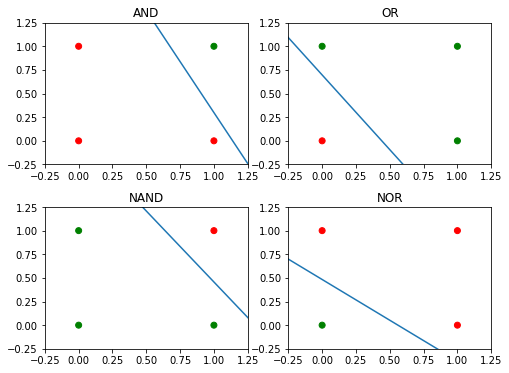

In [6]:
def get_colors(y):
    colors = [None, 'green', 'red']  # class 1: green, class -1: red
    return [colors[c] for c in y]


plt.figure(figsize=(8, 6))
X = np.array(dataset["and"]["X"])  # Coordinates are the same for all boolean logic gates
models = {}

for i, case in enumerate(["and", "or", "nand", "nor"]):
    y = dataset[case]["y"]
    coefs, cls_errors = fit_perceptron(
        insert_intercept(X), 
        np.array(y), 
        learning_rate=0.5,
        max_epochs=15)

    models[case] = {"coefs": coefs, "cls_errors": cls_errors}
    xx = np.linspace(-0.5, 1.5, 10)
    yy = decision_function2d(xx, coefs)

    plt.subplot(221+i)
    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    plt.scatter(X[:,0], X[:,1], c=get_colors(y))
    plt.plot(xx, yy)  # decision boundary
    plt.title(case.upper())


plt.subplots_adjust(hspace=0.30)
plt.show()

## 1.2 Algorithm convergence for AND, OR, NAND, NOR gates

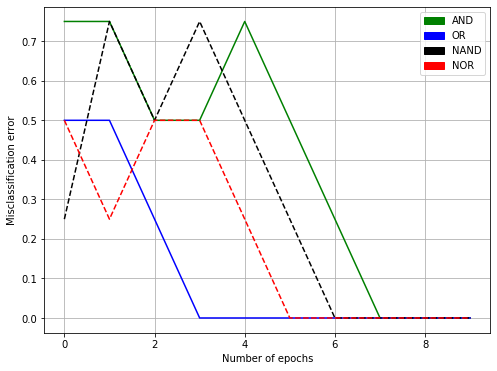

In [7]:
g_patch = mpatches.Patch(color='green', label='AND')
b_patch = mpatches.Patch(color='blue', label='OR')
k_patch = mpatches.Patch(color='black', label='NAND')
r_patch = mpatches.Patch(color='red', label='NOR')

plt.figure(figsize=(8, 6))
plt.plot(range(10), models["and"]["cls_errors"][:10], "-g")
plt.plot(range(10), models["or"]["cls_errors"][:10], "-b")
plt.plot(range(10), models["nand"]["cls_errors"][:10], "--k")
plt.plot(range(10), models["nor"]["cls_errors"][:10], "--r")
plt.grid(True)
plt.ylabel("Misclassification error")
plt.xlabel("Number of epochs")
plt.legend(handles=[g_patch, b_patch, k_patch, r_patch])
plt.show()

## 1.3 XOR gate cannot be fit with linear predictor function (like the Perceptron)

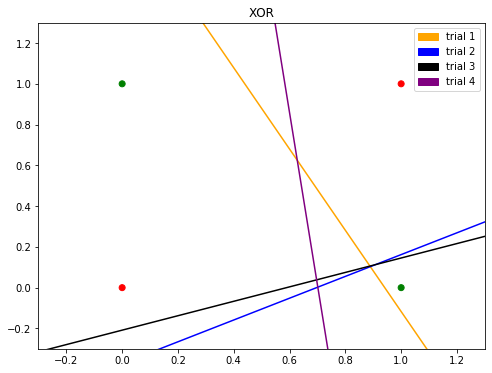

In [8]:
# Learning the decision boundary

case = dataset["xor"]
X = np.array(case["X"])
y = np.array(case["y"])

trials = {
    "trial 1": {"color": "orange"}, 
    "trial 2": {"color": "blue"}, 
    "trial 3": {"color": "black"}, 
    "trial 4": {"color": "purple"}
}
for k, v in trials.items():
    coefs, cls_errors = fit_perceptron(
        insert_intercept(X), 
        y, 
        learning_rate=0.5,
        max_epochs=15
    )
    v["coefs"] = coefs
    v["cls_errors"] = cls_errors


plt.figure(figsize=(8, 6))
plt.xlim(-0.30, 1.30)
plt.ylim(-0.30, 1.30)
plt.scatter(X[:,0], X[:,1], c=get_colors(y))

patches = []
xx = np.linspace(-0.5, 1.5, 10)
for k, v in trials.items():
    patches.append(mpatches.Patch(color=v["color"], label=k))
    yy = decision_function2d(xx, v["coefs"])
    plt.plot(xx, yy, color=v["color"])  # decision boundary

plt.title("XOR")
plt.legend(handles=patches)
plt.show()

## 1.4 XOR trial convergence

trial	#epochs	misclassification errors
 1	15	[0.75, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 2	15	[0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 3	15	[0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 4	15	[0.5, 0.75, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


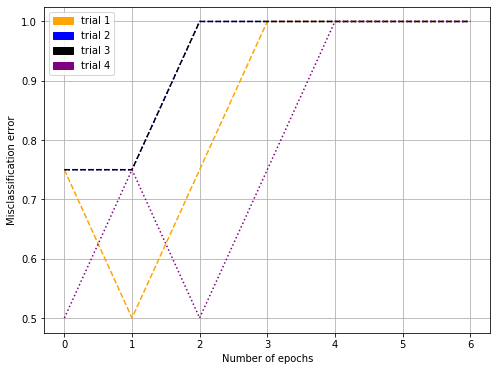

In [9]:
# first print the misclassification errors for each trial
print("trial\t#epochs\tmisclassification errors")
for k, v in trials.items():
    s = f"{k[-2:]}\t{len(v['cls_errors'])}\t{list(v['cls_errors'])}"
    print(s)

# then plot the trials in one graph
plt.figure(figsize=(8, 6))

linestyles = ['--', ':']
i = 0
patches = []
for k, v in trials.items():
    patches.append(mpatches.Patch(color=v['color'], label=k))

    plt.plot(range(7), v["cls_errors"][:7], color=v['color'], ls=linestyles[i])
    i = (i+1) % 2

plt.grid(True)
plt.ylabel("Misclassification error")
plt.xlabel("Number of epochs")
plt.legend(handles=patches)
plt.show()

## Part 2. MNIST digit classification

### Load and preprocess the data

1. Load the first N = 5000 MNIST digits. 
2. Select only those digits in the training set which are either zeros or ones
3. Training set: the first N/2 digits
   Testing set: the remaining N/2 digits

In [10]:
# 1. Load the N = 5000 first digits
images, labels = mnist_reader.load_mnist("data/", kind="train")
images = np.array(images)[:5000]
labels = np.array(labels)[:5000]

# 2. Select only ones with class {0, 1}
mask = (labels == 0) + (labels == 1)
images = images[mask]
labels = labels[mask]

# convert labels from range {0, 1} into range {-1, 1}
ls = [-1 if l==0 else 1 for l in labels]
labels = np.array(ls)

# 3. split into train/test sets
split_idx = int(len(labels)/2)
X_train, y_train = images[:split_idx], labels[:split_idx]
X_test, y_test = images[split_idx:], labels[split_idx:]

#### Sample what the digits look like when plotted

label: -1


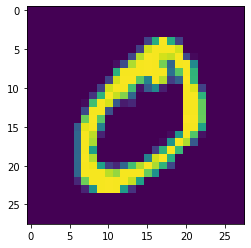

In [11]:
imgidx = 0
print(f"label: {y_train[imgidx]}")
plt.imshow(X_train[imgidx].reshape(28, 28))

### Apply perceptron learning to MNIST training-set

1. Apply implementation of the perceptron algorithm the trainingset data
2. Does the algorithm converge? After how many iterations? 
    - With learning rate 0.1 the algorithm seems to converge after 5 epochs!

In [12]:
coefs, cls_errors = fit_perceptron(X_train, y_train, learning_rate=0.1, max_epochs=10)
print("Misclassification error per epoch:\n", [round(x, 4) for x in cls_errors])

Misclassification error per epoch:
 [0.0134, 0.0077, 0.0019, 0.0058, 0.0038, 0.0, 0.0, 0.0, 0.0, 0.0]


### Test the model with unseen data (test set)

1. On the test set, what is the error rate? 
2. Plot the pixel weights as an image (leaving out the bias weight)

In [13]:
# 1.
preds = predict(X_test, coefs)
conv_preds = convert_labels(preds)
print(f"Classification accuracy on testing set: \n{accuracy(y_test, conv_preds)}")
print(f"\nMisclassification error on testing set: \n{1-accuracy(y_test, conv_preds)}")
print(f"\n# of samples in testing set misclassified: \n{int(X_test.shape[0]*(1-accuracy(y_test, conv_preds)))}")

Classification accuracy on testing set: 
1.0

Misclassification error on testing set: 
0.0

# of samples in testing set misclassified: 
0


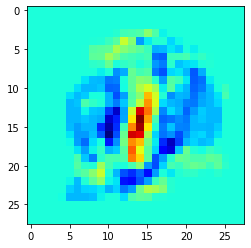

In [14]:
# 2.
plt.imshow(coefs.reshape(28, 28), cmap='jet')

In [15]:
for i in range(392, 420):
    print(coefs[i])

0.8195870164286171
0.01908604318993723
0.6609652098432303
0.23217018995645
0.32084297879866963
-50.59823147251888
-50.21739224716743
-38.8381239051382
-49.79582917501389
-56.74696193577953
-201.05579479782156
-146.44298507992758
-59.50802835503101
174.66545509647702
389.1636721154586
222.4706239279975
32.25606647351723
-101.34295586272995
-91.12791495353447
-75.78490957014765
-90.12271511161327
-49.88380937851052
-39.03015008209963
-50.129546398233416
-49.57604980339856
0.3611668017066487
0.9990184598314229
0.6495210595593387
